In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import joblib

2026-02-26 16:42:25.760348: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-26 16:42:26.637006: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-26 16:42:33.825187: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
PROJECT_PATH = '../'

In [3]:
WINDOW_SIZE = 30
FORECAST_HORIZON = 5

In [4]:
df = pd.read_csv(PROJECT_PATH + 'LSTM_Ready_Dataset_Old.csv')
df

,timestamp,node_cpu_usage_10.35.29.108:10250,node_cpu_usage_10.35.29.109:10250,node_cpu_usage_10.35.29.110:10250,node_mem_usage_10.35.29.108:10250,node_mem_usage_10.35.29.109:10250,node_mem_usage_10.35.29.110:10250,node_cpu_req_unknown,node_cpu_req_aj-aung-k8s-master,node_cpu_req_aj-aung-k8s-worker1,...,node_mem_req_aj-aung-k8s-master,node_mem_req_aj-aung-k8s-worker1,node_mem_req_aj-aung-k8s-worker2,node_cpu_cap_aj-aung-k8s-master,node_cpu_cap_aj-aung-k8s-worker1,node_cpu_cap_aj-aung-k8s-worker2,node_mem_cap_aj-aung-k8s-master,node_mem_cap_aj-aung-k8s-worker1,node_mem_cap_aj-aung-k8s-worker2,cluster_pods_pending
0,2024-01-01 00:00:00,0.208623,5.975408,0.000000,1922273280,2561769472,0.0,0.2,1.2,3.95,...,461373440.0,2.638217e+09,0.000000e+00,4.0,4.0,0.0,8.332218e+09,8.332227e+09,0.000000e+00,2.0
1,2024-01-01 00:01:00,0.326459,5.980638,0.000000,1930141696,2591625216,0.0,0.8,1.2,3.95,...,461373440.0,2.638217e+09,0.000000e+00,4.0,4.0,0.0,8.332218e+09,8.332227e+09,0.000000e+00,5.0
2,2024-01-01 00:02:00,0.219911,5.765409,1.515837,1926356992,2586947584,374190080.0,0.0,1.2,3.95,...,461373440.0,2.638217e+09,1.149239e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.289938e+09,0.0
3,2024-01-01 00:03:00,0.221737,5.879989,2.850323,1940553728,2593882112,388370432.0,0.0,1.2,3.95,...,461373440.0,2.638217e+09,1.417675e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.289938e+09,0.0
4,2024-01-01 00:04:00,0.234354,5.842184,4.132435,1887465472,2598359040,400961536.0,0.0,1.2,3.95,...,461373440.0,2.638217e+09,1.820328e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.289938e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19477,2024-01-14 12:37:00,0.215379,5.160844,5.077805,1995857920,2587627520,409989120.0,0.0,1.2,3.35,...,461373440.0,2.235564e+09,2.222981e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.195566e+09,0.0
19478,2024-01-14 12:38:00,0.200130,5.118348,5.014877,1952833536,2601111552,412585984.0,0.0,1.2,3.35,...,461373440.0,2.235564e+09,2.222981e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.195566e+09,0.0
19479,2024-01-14 12:39:00,0.209720,5.174387,5.084887,1955295232,2584264704,415567872.0,0.0,1.2,3.35,...,461373440.0,2.235564e+09,2.222981e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.195566e+09,0.0
19480,2024-01-14 12:40:00,0.202781,5.333707,5.059837,1951297536,2554994688,416882688.0,0.0,1.2,3.35,...,461373440.0,2.235564e+09,2.222981e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.195566e+09,0.0


In [5]:
df.index = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df

,timestamp,node_cpu_usage_10.35.29.108:10250,node_cpu_usage_10.35.29.109:10250,node_cpu_usage_10.35.29.110:10250,node_mem_usage_10.35.29.108:10250,node_mem_usage_10.35.29.109:10250,node_mem_usage_10.35.29.110:10250,node_cpu_req_unknown,node_cpu_req_aj-aung-k8s-master,node_cpu_req_aj-aung-k8s-worker1,...,node_mem_req_aj-aung-k8s-master,node_mem_req_aj-aung-k8s-worker1,node_mem_req_aj-aung-k8s-worker2,node_cpu_cap_aj-aung-k8s-master,node_cpu_cap_aj-aung-k8s-worker1,node_cpu_cap_aj-aung-k8s-worker2,node_mem_cap_aj-aung-k8s-master,node_mem_cap_aj-aung-k8s-worker1,node_mem_cap_aj-aung-k8s-worker2,cluster_pods_pending
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,2024-01-01 00:00:00,0.208623,5.975408,0.000000,1922273280,2561769472,0.0,0.2,1.2,3.95,...,461373440.0,2.638217e+09,0.000000e+00,4.0,4.0,0.0,8.332218e+09,8.332227e+09,0.000000e+00,2.0
2024-01-01 00:01:00,2024-01-01 00:01:00,0.326459,5.980638,0.000000,1930141696,2591625216,0.0,0.8,1.2,3.95,...,461373440.0,2.638217e+09,0.000000e+00,4.0,4.0,0.0,8.332218e+09,8.332227e+09,0.000000e+00,5.0
2024-01-01 00:02:00,2024-01-01 00:02:00,0.219911,5.765409,1.515837,1926356992,2586947584,374190080.0,0.0,1.2,3.95,...,461373440.0,2.638217e+09,1.149239e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.289938e+09,0.0
2024-01-01 00:03:00,2024-01-01 00:03:00,0.221737,5.879989,2.850323,1940553728,2593882112,388370432.0,0.0,1.2,3.95,...,461373440.0,2.638217e+09,1.417675e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.289938e+09,0.0
2024-01-01 00:04:00,2024-01-01 00:04:00,0.234354,5.842184,4.132435,1887465472,2598359040,400961536.0,0.0,1.2,3.95,...,461373440.0,2.638217e+09,1.820328e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.289938e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-14 12:37:00,2024-01-14 12:37:00,0.215379,5.160844,5.077805,1995857920,2587627520,409989120.0,0.0,1.2,3.35,...,461373440.0,2.235564e+09,2.222981e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.195566e+09,0.0
2024-01-14 12:38:00,2024-01-14 12:38:00,0.200130,5.118348,5.014877,1952833536,2601111552,412585984.0,0.0,1.2,3.35,...,461373440.0,2.235564e+09,2.222981e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.195566e+09,0.0
2024-01-14 12:39:00,2024-01-14 12:39:00,0.209720,5.174387,5.084887,1955295232,2584264704,415567872.0,0.0,1.2,3.35,...,461373440.0,2.235564e+09,2.222981e+09,4.0,4.0,4.0,8.332218e+09,8.332227e+09,7.195566e+09,0.0


In [6]:
cluster_cpu_req = pd.DataFrame({'cluster_cpu_req': df['node_cpu_req_aj-aung-k8s-worker1'] + df['node_cpu_req_aj-aung-k8s-worker2']})

cluster_cpu_req.info()

cluster_cpu_req

<class 'pandas.DataFrame'>
DatetimeIndex: 19482 entries, 2024-01-01 00:00:00 to 2024-01-14 12:41:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cluster_cpu_req  19482 non-null  float64
dtypes: float64(1)
memory usage: 304.4 KB


,cluster_cpu_req
timestamp,
2024-01-01 00:00:00,3.95
2024-01-01 00:01:00,3.95
2024-01-01 00:02:00,5.60
2024-01-01 00:03:00,6.00
2024-01-01 00:04:00,6.60
...,...
2024-01-14 12:37:00,6.60
2024-01-14 12:38:00,6.60
2024-01-14 12:39:00,6.60


In [7]:
cluster_cpu_req.dtypes

cluster_cpu_req    float64
dtype: object

In [8]:
# =====================================================================
# CHRONOLOGICAL SPLIT (70/15/15)
# =====================================================================

n = len(cluster_cpu_req)
train_idx = int(n * 0.7)
val_idx   = int(n * 0.85)

# Split features (for X)
X_train_raw = cluster_cpu_req[:train_idx]
X_val_raw   = cluster_cpu_req[train_idx:val_idx]
X_test_raw  = cluster_cpu_req[val_idx:]

# Split target (for y)
y_train_raw = cluster_cpu_req[:train_idx]
y_val_raw   = cluster_cpu_req[train_idx:val_idx]
y_test_raw  = cluster_cpu_req[val_idx:]

X_train_raw.shape, X_val_raw.shape, X_test_raw.shape, y_train_raw.shape, y_val_raw.shape, y_test_raw.shape

((13637, 1), (2922, 1), (2923, 1), (13637, 1), (2922, 1), (2923, 1))

In [9]:
# =====================================================================
# DUAL SCALING (CRITICAL STEP)
# =====================================================================

# Scaler 1: For Inputs
scaler_inputs  = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = scaler_inputs.fit_transform(X_train_raw)
X_val_scaled   = scaler_inputs.transform(X_val_raw)
X_test_scaled  = scaler_inputs.transform(X_test_raw)

# Scaler 2: For Target
scaler_target  = MinMaxScaler(feature_range = (0, 1))
y_train_scaled = scaler_target.fit_transform(y_train_raw)
y_val_scaled   = scaler_target.transform(y_val_raw)
y_test_scaled  = scaler_target.transform(y_test_raw)

# SAVE BOTH SCALERS IMMEDIATELY
joblib.dump(scaler_inputs, PROJECT_PATH + '/Single-Variable/Single-Var_Scaler_Inputs.pkl')
joblib.dump(scaler_target, PROJECT_PATH + '/Single-Variable/Single-Var_Scaler_Target.pkl')
print("Success: Both scalers saved.")

Success: Both scalers saved.


In [10]:
# =====================================================================
# SLIDING WINDOW (SINGLEVARIATE)\n",
# =====================================================================
    
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size):
	data = []
	labels = []
	start_index = start_index + history_size
	if end_index is None:
		end_index = len(dataset) - target_size
		for i in range(start_index, end_index):
			indices = range(i - history_size, i)
			data.append(dataset[indices])
			labels.append(target[i + target_size])
	return np.array(data), np.array(labels)

X_train, y_train = multivariate_data(X_train_scaled, y_train_scaled, 0, None, WINDOW_SIZE, FORECAST_HORIZON)
X_val  , y_val   = multivariate_data(X_val_scaled  , y_val_scaled  , 0, None, WINDOW_SIZE, FORECAST_HORIZON)
X_test , y_test  = multivariate_data(X_test_scaled ,  y_test_scaled, 0, None, WINDOW_SIZE, FORECAST_HORIZON)

print(f"Train Shape: {X_train.shape}")
print(f"Target Shape: {y_train.shape}")

Train Shape: (13602, 30, 1)
Target Shape: (13602, 1)


In [ ]:
model = Sequential()
model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

2026-02-26 16:52:05.641797: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/testuser/PREDICTIVE-K8S-CA/LSTM_Experiment/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,821 (2.27 MB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 396,548 (1.51 MB)

In [14]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_split = 0.1)

predictions = model.predict(X_test)
predictions = scaler_inputs.inverse_transform(predictions).flatten()
y_test = scaler_target.inverse_transform(y_test.reshape(-1,1)).flatten()

rmse = np.sqrt(np.mean((y_test - predictions)**2))
print(f'RMSE: {rmse:.2f}')

Epoch 1/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0118 - val_loss: 0.0045
Epoch 2/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 3/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 4/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 5/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 6/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 7/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 8/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 9/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 10/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 11/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 12/100
383/38

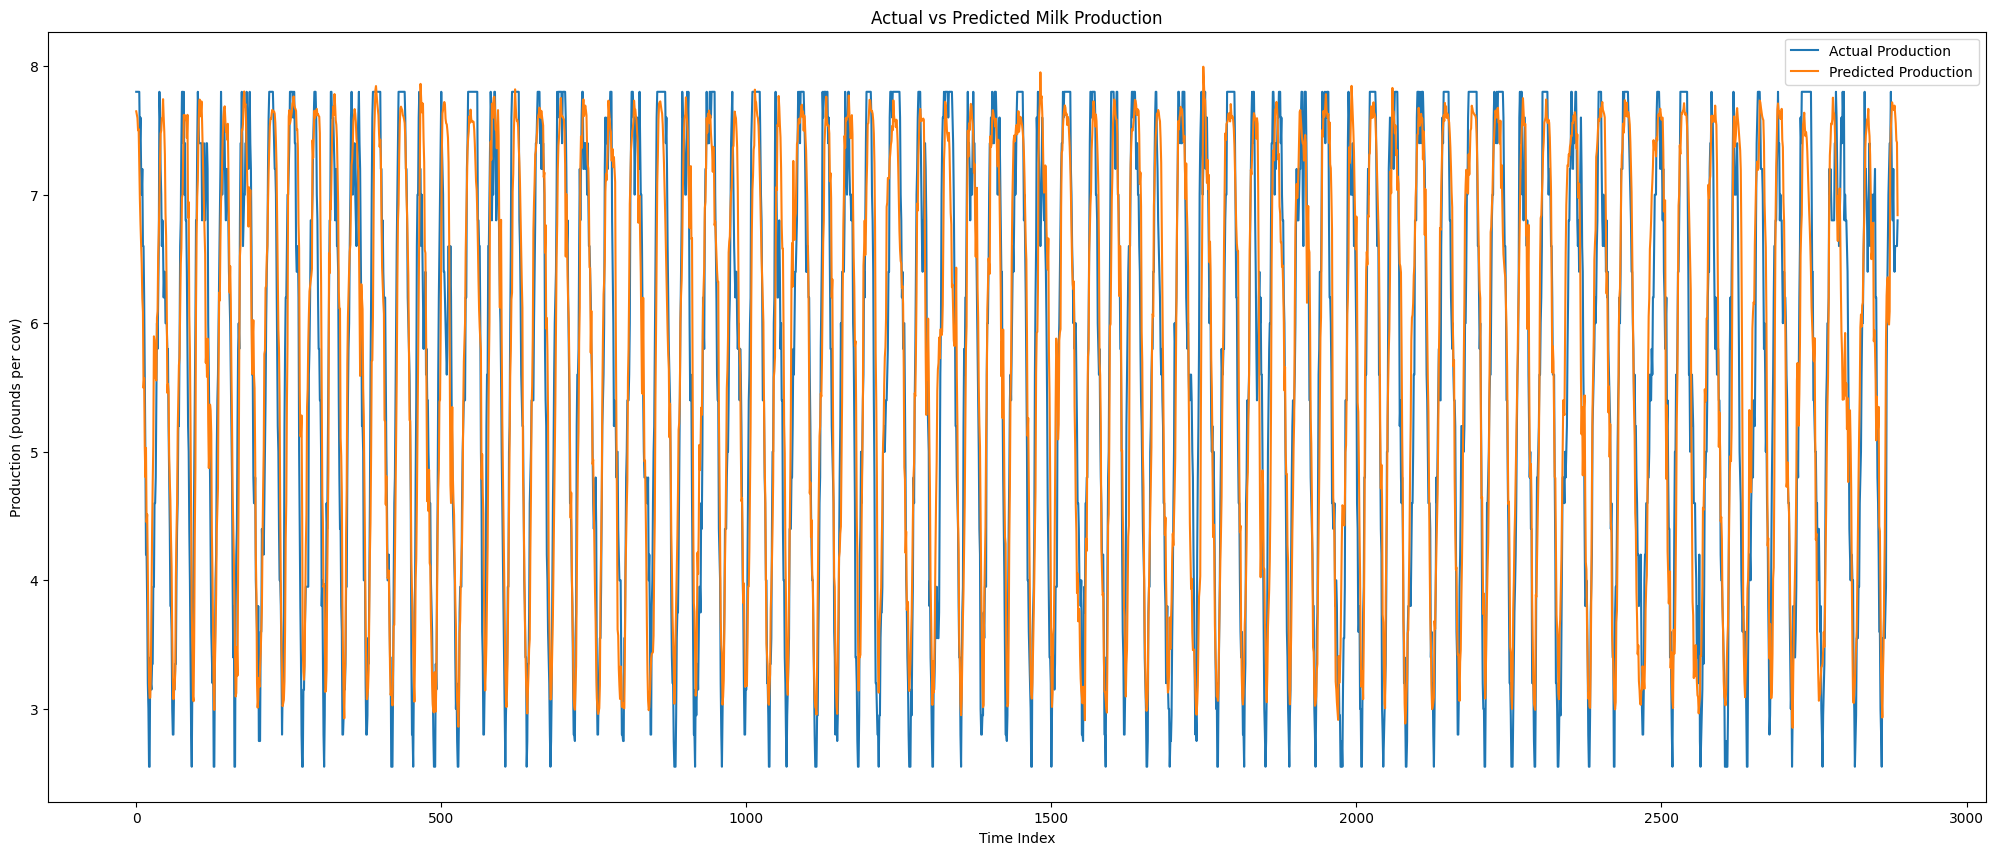

In [17]:
plt.figure(figsize = (25, 10))
plt.plot(y_test, label = 'Actual Production')
plt.plot(predictions, label = 'Predicted Production')
plt.title('Actual vs Predicted Milk Production')
plt.xlabel('Time Index')
plt.ylabel('Production (pounds per cow)')
plt.legend()
plt.show()

In [19]:
# =====================================================================
# EVALUATION & PLOTTING
# =====================================================================
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print("\n--- OFFICIAL AUTOSCALER PERFORMANCE ---")
print(f"Test RMSE: {rmse:.2f} vCores")
print(f"Test MAE:  {mae:.2f} vCores")
print(f"On average, the model's 5-minute forecast is off by {mae:.2f} vCores.")


--- OFFICIAL AUTOSCALER PERFORMANCE ---
Test RMSE: 0.75 vCores
Test MAE:  0.58 vCores
On average, the model's 5-minute forecast is off by 0.58 vCores.


In [ ]:
# Plot Training vs Validation Loss
plt.figure(figsize=(25, 10))
plt.plot(history.history['loss'], label='Training Loss (MSE)', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', color='orange')
plt.title('LSTM Learning Curve: Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Plot Predictions vs Actual on the Test Set
plt.figure(figsize=(25, 10))
plt.plot(real_actuals, label='Actual vCores', color='blue', alpha=0.6)
plt.plot(real_predictions, label='Predicted vCores (5m ahead)', color='red', linestyle='--', alpha=0.8)
plt.title('Test Data: Actual vs Predicted CPU Requests')
plt.xlabel('Time Steps')
plt.ylabel('vCores')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()